<a href="https://colab.research.google.com/github/gltmkm506/alex.us/blob/main/Twitch_Classifier_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/dbamman/nlp22/blob/master/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys, argparse
from scipy import sparse
from scipy.stats import norm
from sklearn import linear_model
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context
import math
import requests
from google.colab import drive
drive.mount('/content/drive')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#import Orthrus Lexicon's Toxic Dictionary
toxic_url = "https://raw.githubusercontent.com/Orthrus-Lexicon/Toxic/main/Toxic%20words%20dictionary.txt"
toxic_dict = requests.get(toxic_url).text.split()

In [ ]:
print(type(toxic_dict), toxic_dict[:10])

<class 'list'> ['***', '*itches', '4r5e', '5h1t', '5hit', 'God', 'God', 'damn', 'Goddamn', 'a**']


In [ ]:
trainingFile = "/content/drive/MyDrive/ap_data/ap_data/37/train.txt"
evaluationFile = "/content/drive/MyDrive/ap_data/ap_data/37/dev.txt"
testFile = "/content/drive/MyDrive/ap_data/ap_data/37/test.txt"

In [ ]:
class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label
        if training:
          X, Y = SMOTE().fit_resample(X, Y)

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

In [ ]:
def orthrus_feat(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word in toxic_dict:
            feats["contains_toxic_word"] = 1
            
    return feats


In [ ]:
simple_classifier = Classifier(orthrus_feat, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: orthrus_feat, Features: 1, Train accuracy: 0.435, Dev accuracy: 0.830


In [ ]:
def wn_feat(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        for sn in wn.synsets(word):
          feats[sn] = 1
            
    return feats

In [ ]:
classifierwn = Classifier(wn_feat, L2_regularization_strength=1.0, min_feature_count=1)
classifierwn.evaluate()

Method: wn_feat, Features: 5095, Train accuracy: 0.940, Dev accuracy: 0.830


In [ ]:
def bigram_feat(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}

    bigrams = nltk.bigrams(text)
    for bigram in bigrams:
        feats[bigram] = 1
    
            
    return feats

In [ ]:
def bigram_feat2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)

    for i in range(0, len(words) - 1):
      feats[words[i] + " " + words[i+1]] = 1
               
    return feats

In [ ]:
classifier2 = Classifier(bigram_feat, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: bigram_feat, Features: 1537, Train accuracy: 0.999, Dev accuracy: 0.835


In [ ]:
def stem_feat(text):
    
    feats = {}
    words = nltk.word_tokenize(text)
    ps = nltk.stem.PorterStemmer()
    for word in words:
      stem = ps.stem(word)
      feats[stem]=1

    
            
    return feats

In [ ]:
classifier3 = Classifier(stem_feat, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: stem_feat, Features: 1279, Train accuracy: 0.999, Dev accuracy: 0.875


In [ ]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)
    for word in words:
      feats[word] = 1

    return feats

In [ ]:
bow_classifier = Classifier(bag_of_words, L2_regularization_strength=0.75, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 1447, Train accuracy: 1.000, Dev accuracy: 0.885


Next, let's combine any or all the features we have developed into one big model and make predictions on the test data.

In [ ]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  all_feats={}
  for feature in [orthrus_feat, wn_feat, bigram_feat2, stem_feat]:
    all_feats.update(feature(text))
  return all_feats

In [ ]:
# testing l2 regularization strength value to find value with best dev accuracy; found to be 0.0
for i in np.arange(0,0.3,0.01):
  big_classifier = Classifier(combiner_function, L2_regularization_strength=i, min_feature_count=1)
  print(i)
  big_classifier.evaluate()

0.0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:811: RuntimeWarning: divide by zero encountered in double_scalars
  args=(X, target, 1.0 / C, sample_weight),
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:301: RuntimeWarning: invalid value encountered in double_scalars
  loss += 0.5 * alpha * squared_norm(w)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:352: RuntimeWarning: invalid value encountered in multiply
  grad[:, :n_features] += alpha * w
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_war

Method: combiner_function, Features: 8643, Train accuracy: 0.333, Dev accuracy: 0.915
0.01
Method: combiner_function, Features: 8643, Train accuracy: 0.945, Dev accuracy: 0.870
0.02
Method: combiner_function, Features: 8643, Train accuracy: 0.978, Dev accuracy: 0.875
0.03
Method: combiner_function, Features: 8643, Train accuracy: 0.986, Dev accuracy: 0.880
0.04
Method: combiner_function, Features: 8643, Train accuracy: 0.993, Dev accuracy: 0.880
0.05
Method: combiner_function, Features: 8643, Train accuracy: 0.995, Dev accuracy: 0.885
0.06
Method: combiner_function, Features: 8643, Train accuracy: 0.995, Dev accuracy: 0.890
0.07
Method: combiner_function, Features: 8643, Train accuracy: 0.997, Dev accuracy: 0.890
0.08
Method: combiner_function, Features: 8643, Train accuracy: 0.997, Dev accuracy: 0.895
0.09
Method: combiner_function, Features: 8643, Train accuracy: 0.997, Dev accuracy: 0.895
0.1
Method: combiner_function, Features: 8643, Train accuracy: 0.997, Dev accuracy: 0.905
0.11


In [ ]:
# using 0.0 as L2_regularization_strength weight throwing error
big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)  
big_classifier.evaluate()
big_classifier.predict()

Method: combiner_function, Features: 8643, Train accuracy: 0.999, Dev accuracy: 0.890


In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
lower, upper=confidence_intervals(0.915, 200, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (0.915, lower, upper))

Test accuracy for best dev model: 0.915, 95% CIs: [0.876 0.954]



 ## Analysis

One of the biggest challenges with our attempt to classify toxic twitch chat messages is the large class inbalance. With roughly 92% of the messages in the dataset being "not toxic" and only 1000 messages in total, the scarcity of "toxic" and "unclear" messages make it very hard for our classifier to learn what makes a message "toxic" or "unclear". Additionally, taking into account the wide range of ways that a message could be toxic, there were likely many new forms of toxicity that were unseen during training. For example, one form of toxicity would be messages that include threats to harm a person or group of people. When annotating, we saw very few examples of messages that fell into this category and thus our classifier likely struggled to identify these forms of toxicity. Despite our classifier falling short of being able to accurately label toxic messages (final dev accuracy was equal to both the majority class and BOW classifiers), let us dig deeper into what was our classifier was able and not able to decipher regarding toxic messages.

Looking at the confusion matrix below for our final classifier, we can see that our classifier is not doing great at indentifying "toxic" and "unclear" messages. Out of the 9 toxic messages in the dev set, our classifier was only able to correctly label 3 of the messages as toxic. The performance was even worse for "unclear" messages, with our classifier correctly identifying 0 out of 8. Again this is likely highly attributed to the class inbalance, which we can also see through the confusion matrix as 183 out of the 200 messages in the dev set had a true label of "not toxic".

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


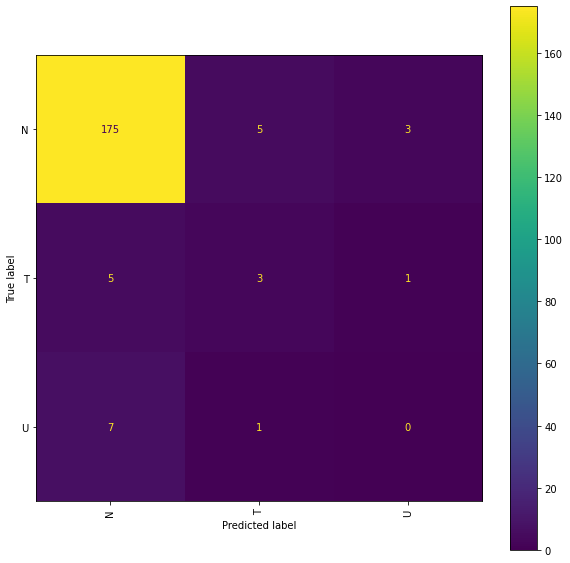

In [ ]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

Next, let us look at the top coefficient weights for each class to understand which features are being considered the most heavily in determining the label. The one feature that appears to be performing as intended is the contain_toxic_word feature, which is a binary label that indicates whether a message contains a toxic word from the Orthrus Lexicon's Toxic Dictionary, since the feature has a high weight for toxic labels and a slighly smaller but still significant weight for unclear labels. Another success in regards to the features is that we were hoping to capture toxic phrases like "u suck" or "f**k you", which appeared to work based on the feature coefficients. However, for the other features used like word sense and the word stems, the feature weights seem to fairly random and doesn't provide much insight on how the model is classifying messages; they were not accurate in reflecting label boundaries. 

In [ ]:
big_classifier.printWeights(n=25)

N	0.578	kennen
N	0.578	kennen carry
N	0.576	wtf
N	0.500	!
N	0.469	lmfao
N	0.467	pogger
N	0.463	@
N	0.360	omegalul
N	0.334	Synset('carry.n.01')
N	0.325	holi
N	0.325	Synset('holy.a.01')
N	0.325	Synset('holy_place.n.01')
N	0.308	jesu
N	0.308	Jesus fuck
N	0.308	Synset('jesus.n.01')
N	0.307	U
N	0.307	LOVE U
N	0.303	it
N	0.289	ninja
N	0.289	Synset('ninja.n.02')
N	0.289	Synset('ninja.n.01')
N	0.274	Synset('information_technology.n.01')
N	0.241	Synset('hello.n.01')
N	0.230	that
N	0.226	holy fuck

T	3.424	pussyyyy
T	1.130	midget
T	1.130	Synset('bantam.s.01')
T	1.111	Synset('dwarf.n.01')
T	0.917	contains_toxic_word
T	0.745	yousif
T	0.745	YOU YOUSIF
T	0.745	FUCK YOU
T	0.717	you
T	0.702	suc
T	0.702	u suc
T	0.669	franc
T	0.669	gtfo
T	0.669	France 😡
T	0.669	gtfo France
T	0.669	😡 gtfo
T	0.669	Synset('france.n.02')
T	0.669	Synset('france.n.01')
T	0.662	she
T	0.647	😡
T	0.575	u
T	0.557	Synset('u.n.03')
T	0.557	Synset('uranium.n.01')
T	0.557	Synset('uracil.n.01')
T	0.456	gettin

U	3.130	reeeeeee
U	3.001	

Last, let's look at the individual data points that are most mistaken. It seems like the model picked up on messages containing words written in all caps. It tended to label this either U or T even when the true label was N. I think the most important information to glean from this is the toxic messages that the model tagged as N because those affect viewers more than false positives. We see that stereotypes ("this music is for men") are not picked up on (at least sometimes) which makes sense: replacing the word "men" with something like "this music is for everyone" makes it a non-toxic sentence. Additionally, we can even think of how in this case the vector representation of "men" is similar to "everyone" because of phrases like man-kind or man-made, to name a few. 
Further, some additional work could be done to improve the word sense or vector representations for domain specific words such as "cheater". This has a greatly negative connotation on Twitch, perhaps even moreso than outside of Twitch. We see that the model missed the toxic message "sup cheater" perhaps in part because of this.

In [ ]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [ ]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,510768,0.998814,T,N,@iwilldominate why do you think an excuse after every death will justify you dying\n
1,549890,0.991426,T,N,@norangeee haha shut up lol\n
2,559274,0.986125,T,N,Hi cheater @highdistortion\n
3,119965,0.973192,U,N,Yeah most of us know better dom\n
4,869100,0.949460,T,N,Sup young buck\n
5,248792,0.911284,N,T,@ChaseShaco luvv u bb\n
6,664946,0.889183,N,U,HAMLINZ CARRY mthRee mthRee\n
7,1795902,0.869442,U,N,when nightbot is more famous than you are\n
8,143421,0.829204,T,N,this music is for men\n
9,128761,0.794677,U,N,people just dont want the truth\n
